In [11]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from evaluation import eval_utils as eu
from plugin.VidToMe.utils import save_video, load_video
from plugin.FastBlend.api import smooth_video
from utils.dataparsers import get_flowid
from utils.flow_utils import warp_flow, get_mask_bwds, compute_fwdbwd_mask

In [7]:
output_dir = "../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device)
else:
    raise NotImplementedError(f"Scene type {config.scene_type} is not supported.")

frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)  

[INFO] frame indexes:  0 2 ... 438 440
[INFO] loaded video with 221 frames from: ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head.mp4
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.mode

[INFO] Saving future flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_future_flow as .pt files
[INFO] Saving past flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_past_flow as .pt files


Loading Flows:   0%|          | 0/221 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers.py:575: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea

[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 777.76it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 8171820 / 67891200


In [18]:
flow_ids = get_flowid(org_frames, flows, mask_bwds, rgb_threshold=0.001).reshape(-1)
_, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)

Assigning flow ids:   0%|          | 0/220 [00:00<?, ?it/s]

Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 675.59it/s]


[INFO] loaded video with 221 frames from: ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/Annotations
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


In [9]:
# save_video(org_frames, output_dir, save_frame=True, fps=15, gif=False, post_fix="_gt")

[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/output_gt.mp4


## 0. DEVA

In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab20")
        cmap_idx = 0 if obj_id is None else (obj_id % 20)
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

/data1/yang_liu/python_workspace/IC-Light/plugin/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/data1/yang_liu/python_workspace/IC-Light/plugin/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


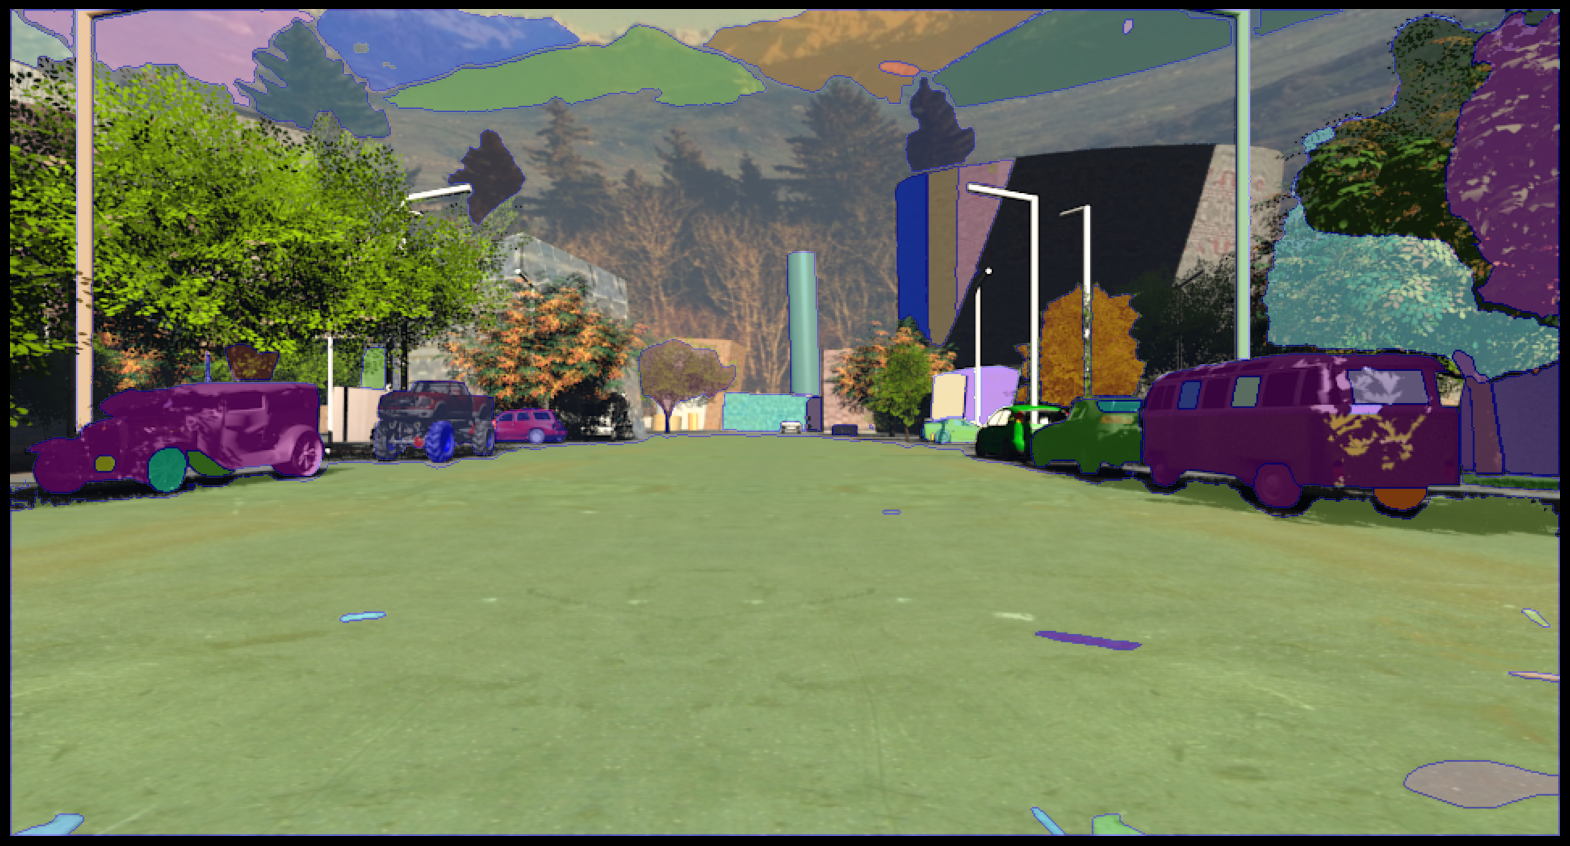

In [6]:
checkpoint = "../models/sam2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
mask_generator = SAM2AutomaticMaskGenerator(
    build_sam2(model_cfg, checkpoint, device=config.device),
    pred_iou_thresh=0.7,
    stability_score_offset=0.8,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)
predictor = build_sam2_video_predictor(model_cfg, checkpoint, device=config.device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    image = org_frames[0].permute(1, 2, 0).cpu().numpy()
    masks = mask_generator.generate(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [7]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    state = predictor.init_state(f'{output_dir}/output_gt.mp4')
    for object_id, object_mask in enumerate(masks):
        predictor.add_new_mask(
            state, 
            frame_idx=0,
            obj_id=object_id,
            mask=object_mask['segmentation'])
    
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

/data1/yang_liu/python_workspace/IC-Light/plugin/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/data1/yang_liu/python_workspace/IC-Light/plugin/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 300/300 [04:49<00:00,  1.04it/s]


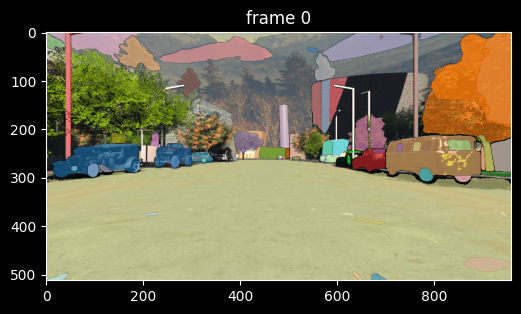

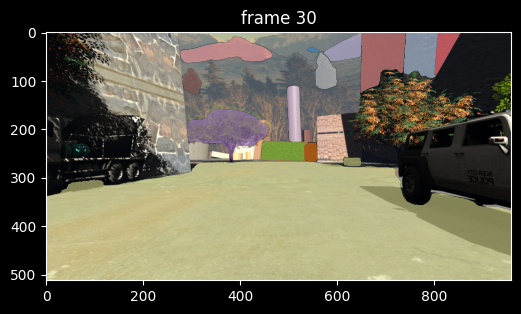

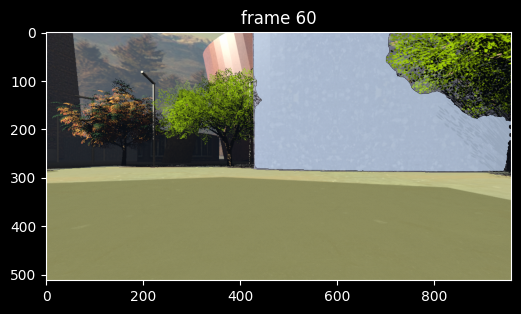

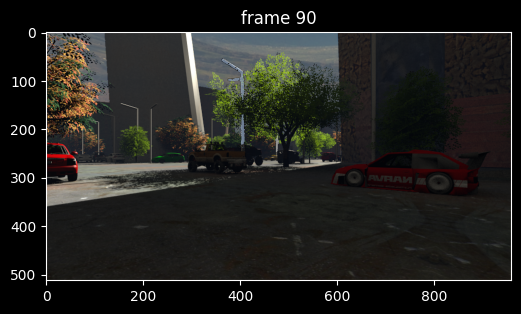

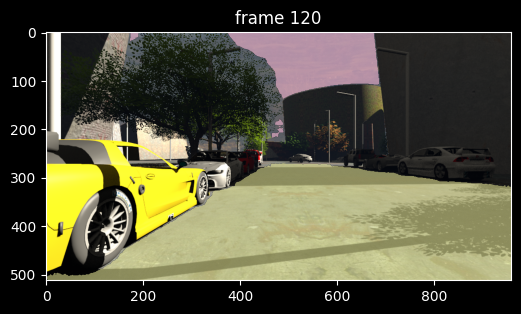

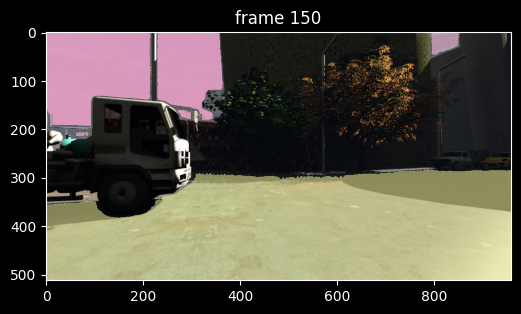

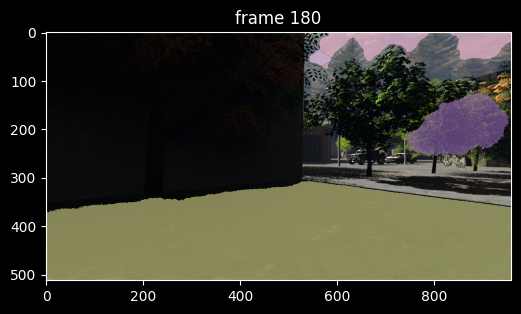

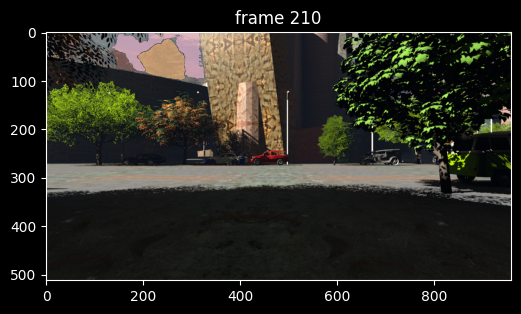

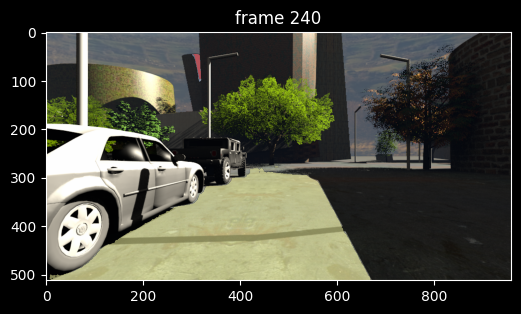

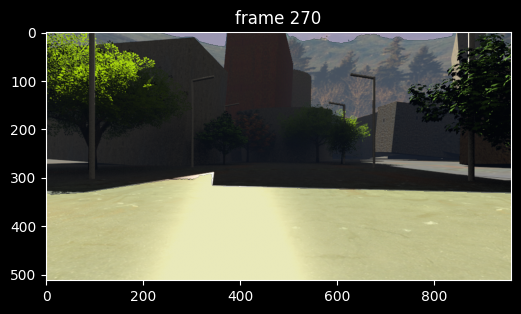

In [8]:
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(org_frames), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(org_frames[out_frame_idx].permute(1, 2, 0).cpu().numpy())
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)